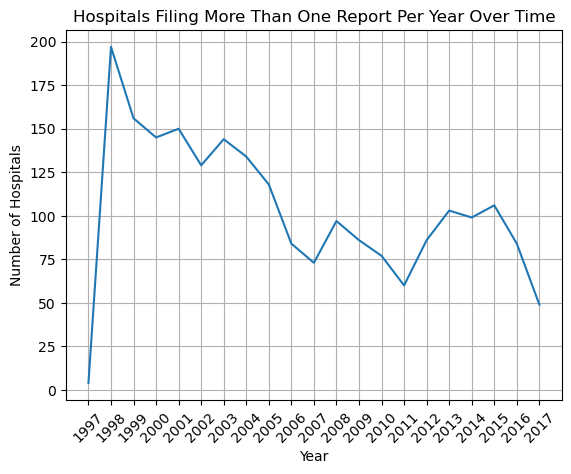

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#read in data
hcris_data=pd.read_csv('/Users/ryanscholte/Desktop/GitHub/HW2/data/output/HCRIS_Datac.csv')
hcris_data_preclean=pd.read_csv('/Users/ryanscholte/Desktop/GitHub/HW2/data/output/HCRIS_Data_preclean.csv')


# Convert 'fy_start' to datetime to extract the year
hcris_data_preclean['fy_start'] = pd.to_datetime(hcris_data_preclean['fy_start'], errors='coerce')
hcris_data_preclean['year'] = hcris_data_preclean['fy_start'].dt.year

# Count hospitals that filed more than one report in the same year
hospital_counts = hcris_data_preclean.groupby(['provider_number', 'year']).size().reset_index(name='report_count')
multiple_reports = hospital_counts[hospital_counts['report_count'] > 1]

# Count number of hospitals per year
hospitals_over_time = multiple_reports.groupby('year')['provider_number'].nunique()

#print(hospitals_over_time)

# Plot the results
plt.figure()
plt.plot(hospitals_over_time.index, hospitals_over_time.values)
plt.xlabel('Year')
plt.xticks(hospitals_over_time.index, rotation=45) 
plt.ylabel('Number of Hospitals')
plt.title('Hospitals Filing More Than One Report Per Year Over Time')
plt.grid(True)
plt.show()


In [3]:
#question 2
# Remove duplicate reports by keeping only the first occurrence per hospital per year
unique_hospitals = hcris_data.drop_duplicates(subset=['provider_number', 'year'])

# Count the number of unique hospital IDs (Medicare provider numbers)
unique_hospital_count = unique_hospitals['provider_number'].nunique()

# Display the result
print("Number of unique hospital IDs:", unique_hospital_count)



Number of unique hospital IDs: 9323


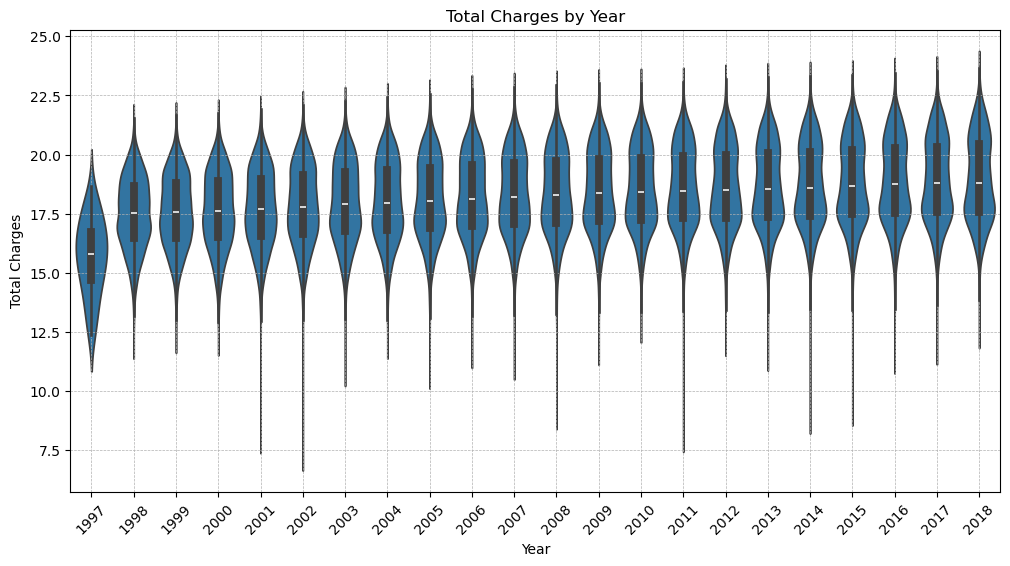

In [4]:
import seaborn as sns
#Question 3
hcris_data['tot_charges'] = pd.to_numeric(hcris_data['tot_charges'], errors='coerce')
# Convert tot_charges to numeric
hcris_data['tot_charges'] = pd.to_numeric(hcris_data['tot_charges'], errors='coerce')
#Remove rows with missing charges or years, negative values to absolute value, and outliers
charges_by_year = hcris_data[['year','tot_charges']].dropna ()
charges_by_year['tot_charges'] = charges_by_year['tot_charges'].abs()


# # Display summary statistics to find cutoff values
summary_stats = charges_by_year ['tot_charges']. describe ()

#creating bounds 
charges_by_year = charges_by_year[charges_by_year['tot_charges'] > 1000]
upper_bound = summary_stats['90%'] if '90%' in summary_stats else summary_stats['max']
charges_by_year = charges_by_year [charges_by_year['tot_charges'] <= upper_bound]
charges_by_year['log_tot_charges'] = np.log(charges_by_year['tot_charges'] + 1)  

# Plot violin plot
plt.figure(figsize=(12, 6)) 
sns.violinplot (x='year', y='log_tot_charges', data=charges_by_year)
plt.title("Total Charges by Year")
plt.xlabel ("Year")
plt.ylabel("Total Charges")
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show( )



59032
count    5.903200e+04
mean              inf
std               NaN
min      1.953267e+00
25%      4.806754e+03
50%      7.161668e+03
75%      1.034881e+04
max               inf
Name: estimated_price, dtype: float64


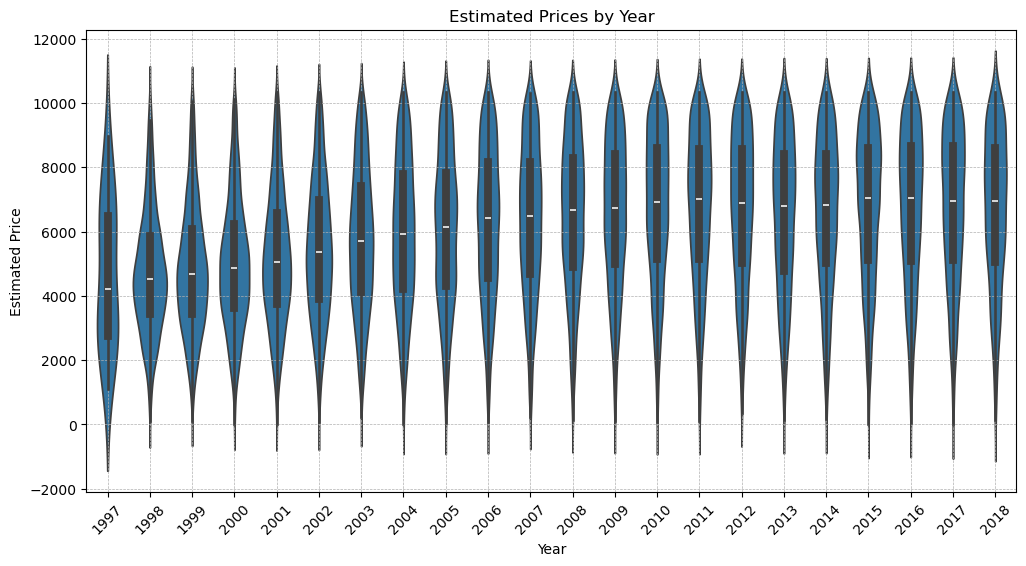

In [5]:
#Question 4
#Converting columns to numeric
numeric_columns = [
    'tot_discounts', 'tot_charges',
    'ip_charges', 'icu_charges', 'ancillary_charges',
    'tot_mcare_payment', 'tot_discharges', 'mcare_discharges'
]
hcris_data[numeric_columns] = hcris_data[numeric_columns].apply(pd.to_numeric, errors='coerce')
# Remove missing values
hcris_clean = hcris_data[['year'] + numeric_columns].dropna( )

# Calculate estimated price based on the formula
discount_factor = 1 - hcris_clean['tot_discounts'] / hcris_clean ['tot_charges']
price_num = (hcris_clean['ip_charges'] + hcris_clean['icu_charges'] + hcris_clean['ancillary_charges']) * discount_factor - hcris_clean[ 'tot_mcare_payment']
price_denom = hcris_clean['tot_discharges'] - hcris_clean ['mcare_discharges']

hcris_clean['estimated_price'] = price_num/price_denom
#removing outliers and negatives
hcris_clean = hcris_clean[hcris_clean['estimated_price'] > 0]
print(len(hcris_clean))
summary_stats = hcris_clean['estimated_price'].describe()
print (summary_stats)

upper_bound = summary_stats ['75%'] if '75%' in summary_stats else summary_stats ['max']
hcris_clean = hcris_clean[hcris_clean['estimated_price'] <= upper_bound]
#Plot violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='year', y='estimated_price', data=hcris_clean)
plt.title("Estimated Prices by Year")
plt.xlabel ("Year")
plt.ylabel("Estimated Price")
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt. show()

In [6]:
#Q5.

# Filter data to only include year 2012
hcris_2012 = hcris_data[hcris_data['year'] == 2012].copy()

# Calculate estimated price using the given formula
hcris_2012['discount_factor'] = 1 - (hcris_2012['tot_discounts'] / hcris_2012['tot_charges'])
hcris_2012['price_num'] = (hcris_2012['ip_charges'] + hcris_2012['icu_charges'] + hcris_2012['ancillary_charges']) * hcris_2012['discount_factor'] - hcris_2012['tot_mcare_payment']
hcris_2012['price_denom'] = hcris_2012['tot_discharges'] - hcris_2012['mcare_discharges']
hcris_2012['price'] = hcris_2012['price_num'] / hcris_2012['price_denom']

# Define penalty
hcris_2012['penalty'] = (hcris_2012['hrrp_payment'] + hcris_2012['hvbp_payment']) < 0

# Clean data
hcris_2012 = hcris_2012[(hcris_2012['price_denom'] > 100) & (hcris_2012['price_num'] > 0) & (hcris_2012['price'] > 0)]
hcris_2012 = hcris_2012[hcris_2012['beds'] > 30]
hcris_2012 = hcris_2012[hcris_2012['price'] < 100000]  

# NA payments
hcris_2012['hvbp_payment'] = hcris_2012['hvbp_payment'].fillna(0)
hcris_2012['hrrp_payment'] = hcris_2012['hrrp_payment'].fillna(0).abs()


# Calculate average price for penalized vs non-penalized hospitals
mean_penalized = round(hcris_2012.loc[hcris_2012['penalty'] == 1, 'price'].mean(), 2)
mean_non_penalized = round(hcris_2012.loc[hcris_2012['penalty'] == 0, 'price'].mean(), 2)

print(f"Mean price for penalized hospitals: {mean_penalized}")
print(f"Mean price for non-penalized hospitals: {mean_non_penalized}")

Mean price for penalized hospitals: 10171.54
Mean price for non-penalized hospitals: 9651.82


In [7]:
#Q6
hcris_2012['beds_quartile'] = pd.qcut(hcris_2012['beds'], 4, labels=[1, 2, 3, 4])

# Create indicator variables for each quartile
for i in range(1, 5):
    hcris_2012[f'quartile_{i}'] = (hcris_2012['beds_quartile'] == i).astype(int)


# Calculate average price for treated and control groups within each quartile
Avg_per_group = []
for i in range(1, 5):
    treated_mean = hcris_2012.loc[(hcris_2012[f'quartile_{i}'] == 1) & (hcris_2012['penalty'] == 1), 'price'].mean()
    control_mean = hcris_2012.loc[(hcris_2012[f'quartile_{i}'] == 1) & (hcris_2012['penalty'] == 0), 'price'].mean()
    Avg_per_group.append({'Quartile': i, 'Penalized_Mean_Price': round(treated_mean, 2), 'Non_penalized_Mean_Price': round(control_mean, 2)})

results_df = pd.DataFrame(Avg_per_group)
print(results_df.to_string(index=False))

 Quartile  Penalized_Mean_Price  Non_penalized_Mean_Price
        1               7581.19                   7871.93
        2               9835.01                   8584.81
        3               9982.35                   9930.10
        4              12435.12                  12263.70


In [8]:
from causalinference import CausalModel
import warnings
warnings.simplefilter('ignore')


hcris_2012['bed_quartile'] = pd.qcut(hcris_2012['beds'], 4, labels=False)
bed_quart_dummies = pd.get_dummies(hcris_2012['bed_quartile'], prefix='bed_quart').iloc[:, :-1] * 1
bed_quart_dummies = bed_quart_dummies.sub(bed_quart_dummies.mean(axis=0), axis=1)


y = hcris_2012['price'].values
D = hcris_2012['penalty'].values
X = bed_quart_dummies.values
causal_model = CausalModel(Y=y, D=D, X=X)

results = pd.DataFrame(index=['ATE', 'SE'], columns= ['INV', 'MAH', 'IPW', 'OLS'])

# Estimate with inverse weighting
causal_model.est_via_matching(weights='inv', matches=1, bias_adj=True)
inv_ate = causal_model.estimates['matching']['ate']
inv_se = causal_model.estimates['matching']['ate_se']
results.loc['ATE', 'INV'] = inv_ate
results.loc['SE', 'INV'] = inv_se


# Estimate with Mahalanobis distance
causal_model.est_via_matching(weights='maha', matches=1, bias_adj=True)
maha_ate = causal_model.estimates['matching']['ate']
maha_se = causal_model.estimates['matching']['ate_se']
results.loc['ATE', 'MAH'] = maha_ate
results.loc['SE', 'MAH'] = maha_se


# Estimate Propensity Scores using the built-in method
causal_model.est_propensity()
causal_model.est_via_weighting()
ipw_ate = causal_model.estimates['weighting']['ate']
ipw_se = causal_model.estimates['weighting']['ate_se']
results.loc['ATE', 'IPW'] = ipw_ate
results.loc['SE', 'IPW'] = ipw_se

causal_model.est_via_ols(adj=2)
ols_ate = causal_model.estimates['ols']['ate']
ols_se = causal_model.estimates['ols']['ate_se']
results.loc['ATE', 'OLS'] = ols_ate 
results.loc['SE', 'OLS'] = ols_se 

print(results)



            INV         MAH         IPW         OLS
ATE  299.275537  299.275537  299.275537  299.275537
SE   624.023041  624.023041  573.963946  573.857613
